## Dive Into Seattle Airbnb Data

### Project

**Business Understanding**: From the datasets we can get a better knowledge how we can set the rental price for peroperties of Seattle Airbnb. Three business aspect questions were asked before diving into the dataset:

1. How does the neighborhood affect the price?
2. What are the busiest times of the year to visit Seattle? By how much do prices spike?
3. What are the most influential factors to estimate price in Seattle Airbnb Listing Data?

**Evaluate the Results**: Result and discussion are published in https://medium.com/@shihaowen/dive-into-boston-and-seattle-airbnb-data-b4a9e79b740c.

In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [322]:
#read data
cal = pd.read_csv('calendar.csv')
listing = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

#### Question 1

**1.** How does the neighborhood affect the price?

In [323]:
price_neighbourhood = listing[['price','neighbourhood']].copy()
price_neighbourhood = price_neighbourhood.dropna(subset=['price'])
price_neighbourhood['price']=price_neighbourhood.price.str.extract('(\d+)')
price_neighbourhood['price']=pd.to_numeric(price_neighbourhood['price'])
mean_price_neighbourhood = price_neighbourhood[['price','neighbourhood']].groupby('neighbourhood').mean().reset_index()

In [324]:
mean_price_neighbourhood.head()

,neighbourhood,price
0,Alki,196.652174
1,Arbor Heights,118.000000
2,Atlantic,116.280000
3,Ballard,123.615023
4,Belltown,166.627451


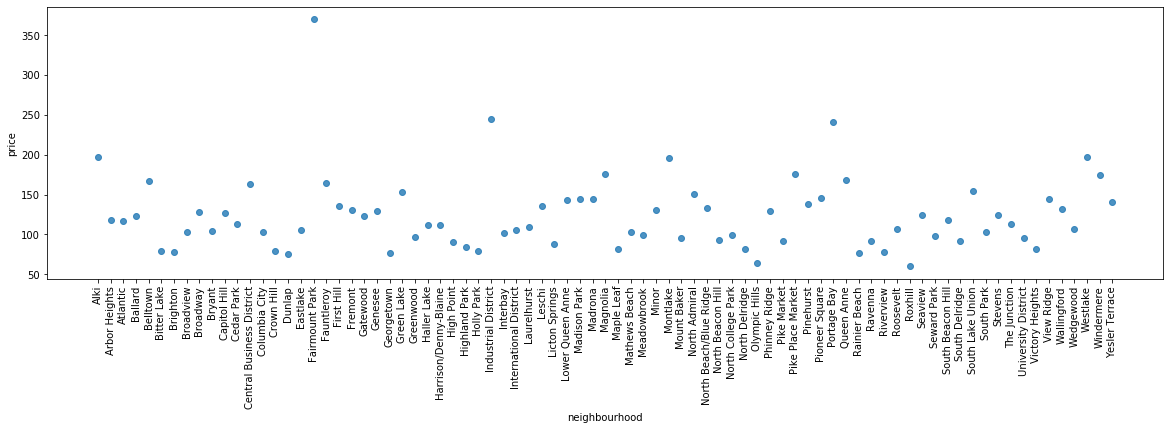

In [325]:
import seaborn as sns 
# use the function regplot to make a scatterplot
plt.figure(figsize=(20,5))
sns.regplot(x=mean_price_neighbourhood["neighbourhood"], y=mean_price_neighbourhood['price'],fit_reg=False)
plt.xticks(rotation=90)
plt.show()

**Response**: Here we can see that some neighbourhood have a high price (Fairmount Park) compared to others (Roxhill)

#### Question 2

**2.** What are the busiest times of the year to visit Seattle? By how much do prices spike?

In [326]:
#Preprocess the calender
cal['date']=pd.to_datetime(cal['date']) 
cal['year']=pd.DatetimeIndex(cal['date']).year
cal['month']=pd.DatetimeIndex(cal['date']).month
#Remove 2017 because we have only one month data
cal_2016=cal[cal['year']==2016]
#Agreggate the data to get the number of appartement available per month per year based on the available column
availability = pd.DataFrame(cal_2016.groupby(['month','available']).size()).reset_index()
#Create a copy and delete rows with missing price
cal_copy=cal_2016.copy()
cal_copy=cal_copy.dropna(subset=['price'])
#Convert the price column to int
cal_copy['price']=cal_copy.price.str.extract('(\d+)')
cal_copy['price']=pd.to_numeric(cal_copy['price'])
#Calculate mean of price by month
price_by_month=cal_copy[['month','price']].groupby('month').mean().reset_index()

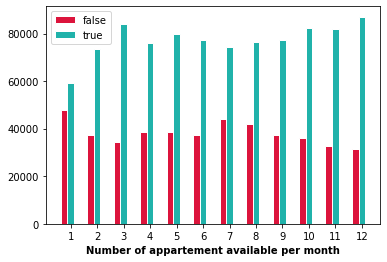

In [338]:
#Visualize the availaility per month

barWidth = 0.25
 
# set height of bar
bars1 = []
bars2 = []
for month in range(1,13):
    bars1.append(list(availability[availability['month']==month][0])[0])
    bars2.append(list(availability[availability['month']==month][0])[1])
    
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#dc143c', width=barWidth, edgecolor='white', label='false')
plt.bar(r2, bars2, color='#20B2AA', width=barWidth, edgecolor='white', label='true')

 
# Add xticks on the middle of the group bars
plt.xlabel('Number of appartement available per month', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['1', '2', '3', '4', '5','6','7','8','9','10','11','12'])
 
# Create legend & Show graphic
plt.legend()
plt.show()


In [328]:
sort_index = np.argsort(np.array(bars1))+1
sort_index[::-1]

array([ 1,  7,  8,  4,  5,  2,  6,  9, 10,  3, 11, 12], dtype=int64)

**Response**: Here we can see that January,July and August are the busiest months of the year to visit Seattle

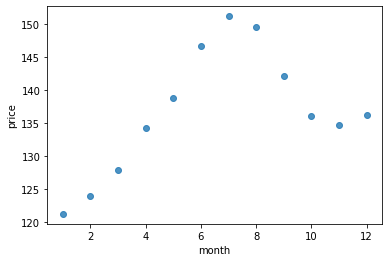

In [329]:
import seaborn as sns 
# use the function regplot to make a scatterplot
sns.regplot(x=price_by_month["month"], y=price_by_month['price'], fit_reg=False)

In [330]:
sort_index = np.argsort(np.array(bars))+1
sort_index[::-1]

array([ 7,  8,  6,  9,  5, 12, 10, 11,  4,  3,  2,  1], dtype=int64)

**Response**: The prices are hight at the summer periode (July & August) witch belongs to top 3 busiest months, we observe that hte prices get high also by the end of the year (December)

#### Question 3

**3.** What are the most influential factors to estimate price in Seattle Airbnb Listing Data?

In [331]:
listing['price']=listing.price.str.extract('(\d+)')
listing['price']=pd.to_numeric(listing['price'])
listing['security_deposit']=listing.security_deposit.str.extract('(\d+)')
listing['security_deposit']=pd.to_numeric(listing['security_deposit'])
listing['cleaning_fee']=listing.cleaning_fee.str.extract('(\d+)')
listing['cleaning_fee']=pd.to_numeric(listing['cleaning_fee'])
listing['extra_people']=listing.extra_people.str.extract('(\d+)')
listing['extra_people']=pd.to_numeric(listing['extra_people'])

In [332]:
model_data=listing.copy()

In [333]:
model_data = model_data.dropna(subset=['square_feet'])
model_data = model_data.fillna(0)

In [334]:
# 16 Numerical variables: I think that they have impact while predicting price.
columns = ['accommodates','bathrooms','bedrooms','beds','square_feet','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','availability_30','availability_60','availability_90','availability_365','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','calculated_host_listings_count','reviews_per_month']
X = model_data[columns]
# Price is assigned to y as predicted column.
y = model_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Four steps:

#Instantiate
model = LinearRegression(normalize=True) 

#Fit - why does this break?
model.fit(X_train, y_train) 

#Predict using your model
y_test_preds = model.predict(X_test)
y_train_preds = model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [335]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = model.coef_
    coefs_df['abs_coefs'] = np.abs(model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
19,review_scores_checkin,-32.654409,32.654409
21,review_scores_location,28.066753,28.066753
18,review_scores_cleanliness,23.911443,23.911443
20,review_scores_communication,-16.530768,16.530768
0,accommodates,16.478350,16.478350
24,reviews_per_month,-15.978719,15.978719
22,review_scores_value,-15.526714,15.526714
17,review_scores_accuracy,-8.182550,8.182550
2,bedrooms,6.272949,6.272949
7,guests_included,4.987060,4.987060


**Response**: If we eliminate the reviews columns, than we can say that the price is mostly affected in order by:

 +accomodates
 
 +bedrooms
 
 +bathrooms
 
 +beds
 
 +minimun nights
 
 +extra_people